# Running an Online Backtesting Pipeline

In this notebook we will demonstrate the pipeline testing infractructure provided by `olac`. The goal is to have a consistent and configurable way of testing out different models and training and labelling strategies, without worrying about how to track results. A new infrastructire is needed due to the dynamic nature of the models, which makes a static train/test scenario inappropriate. 

We will demonstrate the pipeline by implementing our own training and labelling strategies, and backtesting the results.

The core functionality of the pipeline is provided by the `Pipeline` class. A `Pipeline` object consists of:
* A `data_generator`, from which new data points are pulled. This may also be a list or any other iterable object.
* A `model`, which is used for prediction on each new data point
* A `predictor`, which decides how to make predictions and when to retrain or update the model
* A `labeller`, which decides when and how to buy new labels.


The idea behind the backtesting procedure is to have two parallel processes. One continuously gets new data points, updates the model, and makes predictions. The other gathers the newly arrived points, buys labels for them using some strategy, and gives them back to the predicting process for updating the model. To facilitate this, the `Pipeline` also exposes objects for communication between the processes:
* A `labelling_queue`, for new points that have been predicted and are now waiting to be labelled (or not)
* A `training_queue`, for points that have been labelled and are now waiting to be used for updating the model.

Note that queues are objects that accept objects and return them in the order they arrived (first in, first out). Once an object has been gotten from a queue then it is no longer availble in the queue, i.e. the queue gets smaller. The builtin queues only allow getting and putting one item at a time, so the `pipeline` uses custom `olac.pipeline.BatchQueues` which provide the convenience methods `get_all` and `put_all` for emptying the whole queue and putting an entire list of items back in.

The queues contain `QueuePoint`s, which are data objects containing:
* `point`: the datapoint itself, which is usually a numpy array
* `index`: the index of the points as it leaves the `data_generator` (this is important for keeping track of the order of the results after the pipeline is run)
* `predicted_label`
* `prob`: Some measure of uncertainty, like the output from the `model`'s `decision_function` or `predict_proba` methods.
* `true_label`
 
The basic backtesting procedure is to initualize the pipeline with a data generator, a model, a predictor, and a labeller, and then to run the test using `pipeline.run()`. After running the pipeline, the results are returned as lists of QueuePoints in the order that they occured for replaying or further analysis. 

In [1]:
import warnings
warnings.filterwarnings('ignore', message='.*')

In [2]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

In [3]:
import olac

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import PassiveAggressiveClassifier
import sklearn

To start off with, we select a dataset and a model. We choose something simple. Note that the model can actually be a `sklearn.pipeline` if there is any preprocessing involved, as long as it implements the methods we use in our `Predictor`.

For our example we will use the online `PassiveAgressiveClassifier` on the roving balls dataset with 1000 points.

To begin setting up our pipeline we first implement our label buying strategy. This is achieved by subclassing the `olac.pipeline.LabellerBase` class and implementing the `buy_labels_condition` and `buy_labels` methods. 

As the name suggests, `buy_labels_condition` decides when to buy new labels. It is called continuously when the labelling process is not busy with labelling. It should return `True` when the condition for buying new labels is met. If calculating the condition requires access to the data points themselves, make sure to store them in an object property as they will no longer be available in the queue for use by `buy_labels`.

In `buy_labels`, which gets called whenever `buy_labels_condition` is True, we should split the available points into *labelled* and *unlabelled* lists using some strategy. The method should return these as two lists of QueuePoints: one for which labels have been bought, and the other for the remaining unlabelled points. **The `pipeline` handles making the returned labelled points available to the predictor for updating the model.**

Each of these methods recieves as an argument the `Pipeline` object itself. `pipeline.labelling_queue` contains the points that are waiting for a decision on labelling.

The labeller is a stateful, so issues like tracking a budget for buying labels can be handled by setting additional properties of the object. The same is true for accumulating additional results. We demonstrate this below.


Our labelling strategy will be very simple: We wait until the number of available points in the `labelling_queue` (accessible using `labelling_queue.qsize()`) reaches a certain threshold, and then we label some percentage of the points randomly. We use an internal property to keep track of how many labels we have bought, for budgeting purposes and also so we can double check our output after the pipeline is run. We make the threshold and the labelling probability configurable by including them as properties in our `__init__` method.

Note that our methods must always accept the arguments `self` and `pipeline`, which gives access to the overall pipeline for talking to the queue.

We will add some print statements to help is see what's going on while the pipeline is running.

This example labeller is also available in `olac.pipeline`.

In [5]:
class NaieveLabeller(olac.pipeline.LabellerBase):
    """ A Naieve 

    """
    def __init__(self, threshold, decider, decider_args=tuple(), decider_kwargs=dict()):
        """

        Parameters
        ----------
        threshold: The minimum number of points to trigger a batch of labelling
        prob: The probability with which each point will recieve a label.
        """
        self.threshold = threshold
        self.decider = decider
        self.decider_args = decider_args
        self.decider_kwargs = decider_kwargs
        self.labels_bought = 0
        self.cost_points = []

    def buy_labels_condition(self, pipeline,):
        """Buy labels if the labelling_queue is longer than the threshold."""
        n = pipeline.labelling_queue.qsize()
        if n > self.threshold:
            print(f'Labeller:\tThreshold met, {n} new points avaible in queue')
            return True
        else:
            return False
        

    def buy_labels(self, pipeline,):
        """Get all the points from the labelling queue and label them with
        some probability. """
        labelled_points = []
        unlabelled_points = []
        cost_point = []

        # Get all the points from the queue (queue will now be empty)
        points = pipeline.labelling_queue.get_all()
        
        # use the decider function to create a list of which points to investigate an which not
        decider = self.decider(self, points, *self.decider_args, **self.decider_kwargs)
        
        # calculate the cost of the investigation
        cost = olac.cost_of_label.cost_of_label(data=points, decision=decider, salary=-1.5, data_type='array')
        
        # store the data points 
        for i, point in enumerate(points):
            if decider[i] == 1:
                labelled_points.append(point)
            else:
                unlabelled_points.append(point)
                
        self.cost_points += [cost.sum()]
        print(f'Labeller:\tLabelled {len(labelled_points)} new points')

        return labelled_points, unlabelled_points

Finally we implement a predictor. The approach is very similar to implementing the labeller, except that now we have three methods we need to implement: `train_condition`, `train_pipeline_model`, and `do_prediction`.

The prediction worker calls these methods in approximately the following loop:

```python
for new_point in data_list:
    if train_condition(pipeline):
        train_pipeline_model(pipeline)
    x = new_point[:-1]
    y_pred, prob = do_prediction(pipeline, x)
```

`train_condition` is the condition for training or updating the model. For online models, this can happen whenever there are new labels available. Any available labelled points will appear in `pipeline.training_queue`. If calculating the condition requires access to the datapoints themselves, make sure to store them in an object property as they will no longer be available in the queue for `train_pipeline_model`. 

In `train_pipeline_model` we should access the `pipeline.model`, which is usually a scikit-learn model, and train or update it using the labelled points available in the `pipeline.training_queue`. 

`do_prediction` should accept as arguments the `pipeline` object as well as `x`, the point to be predicted. It should access the `pipeline.model` for making the prediction. This method should return two numbers: the prediction itself, as well as a measure of the model's certainty (usually given by `model.decision_function` or `model.predict_proba`).  **The `pipeline` handles making the returned prediction and certainty. as well as the data point available to the labeller for buying labels.**

Again we use a simple strategy, which should actually be the default for online models: whenever there are any new labelled points available (`training_queue.empty()` is `False`), we update the model using all the available points. We make the training set for updating by looping through the available QueuePoints and getting the points themselves (arrays) and the true labels, stacking them into `numpy` arrays, and then calling `partial_fit` on the model.

For prediction, we simply call the model's predict method with the new datapoint (recall that the data generator yields points of the form `[x0, x1, ..., y]`). If we are trying to make a prediction beofre the model has ever been updated, we will get an error from scikit-learn. We handle this by simply returning `np.nan`s for both the prediction and the probability.

In [6]:
class OnlinePredictor(olac.pipeline.PredictorBase):
    """A simple predictor for use with online models. The corresponding
    pipeline.model should implement the partial_fit and the decision_function
    methods.

    """
    def train_condition(self, pipeline,):
        """Train anytime there are points available in the training queue"""
        return not pipeline.training_queue.empty()

    def train_pipeline_model(self, pipeline,):
        """
        Update the model using all points available in the training queue
        using pipeline.model.partial_fit.
        """
        points = pipeline.training_queue.get_all()  # training_queue is now empty
        print(f'Predictor:\t{len(points)} new points available, training...')

        X_train = np.vstack([np.array(p.point) for p in points])
        y_train = np.array([p.true_label for p in points])

        pipeline.model.partial_fit(X_train, y_train, classes=[0, 1])

    def do_prediction(self, pipeline, x,):
        """
        Make a prediction. If the model has not yet been fit (burn-in phase),
        return NaNs.
        """
        try:
            y_pred = pipeline.model.predict([x])
            prob = pipeline.model.decision_function([x])

        # still burning in, return NaNs.
        except sklearn.exceptions.NotFittedError:
            y_pred = np.nan
            prob = np.nan

        return y_pred, prob


Finally, it's time to run our pipeline. We set up our data generator and model, and also create instances of our labeller and our predictor. Then we pass them all to the pipeline and run it.

Running the pipeline is as easy as calling `pipeline.run()`. This method returns two lists: the points for which we bought labels, and the points that we did not buy labels for. Running the pipeline can take some time, but since we have included print statements in our labeller and predictor we should be able to see what is going on.

We had 1000 points in our dataset, so let's make our labelling threshold 100, and label approximately 10% of the points.

In [7]:
model = PassiveAggressiveClassifier()
data = olac.data_generators.roving_balls(steps=1000)

labeller = NaieveLabeller(threshold=100, decider=olac.cost_of_label.simple_decider, decider_kwargs={'prob': 0.1})
predictor = OnlinePredictor()

# create the pipeline
pipeline = olac.pipeline.Pipeline(data, model, predictor, labeller)

# run the backtest and get the results
train_set, eval_set = pipeline.run()

Labeller:	Threshold met, 189 new points avaible in queue
evaluate the array of data in queue
finished evaluate the array
Labeller:	Labelled 20 new points
Labeller:	Threshold met, 225 new points avaible in queue
Predictor:	20 new points available, training...
evaluate the array of data in queue
finished evaluate the array
Labeller:	Labelled 19 new points
Labeller:	Threshold met, 175 new points avaible in queue
evaluate the array of data in queue
finished evaluate the array
Labeller:	Labelled 19 new points
Predictor:	38 new points available, training...
Labeller:	Threshold met, 161 new points avaible in queue
evaluate the array of data in queue
finished evaluate the array
Labeller:	Labelled 19 new points
Predictor:	19 new points available, training...
Labeller:	Threshold met, 128 new points avaible in queue
evaluate the array of data in queue
finished evaluate the array
Labeller:	Labelled 24 new points


In [8]:
labeller.cost_points

[3.0, -4.5, -1.5, -4.5, 12.0]

Awesome! Note that since getting new data points is so fast, the amount of points in the label queue was piling up more quickly than they could be processed, which is why the nubmer of points available was sometimes higher than the threshold.

We expect that we labelled about 10% of the points, which we can check:

In [9]:
print(len(train_set), 'points labelled.')

101 points labelled.


Recall that we also customized our labeller with a budget tracker that counted how many labels had been bought. We can check that this has been updated properly by getting it from our labeller object:

In [10]:
print(labeller.labels_bought, 'labels bought from budget.')

0 labels bought from budget.


Obviously this permits a lot of flexibility, like adjusting the label probablilty based on how much of a budget is available, or not labelling any more points once the budget is used up.

Now we want to check out our model's performance. Currently `train_set` and `eval_set` (the unlabelled points) are lists of `QueuePoint`s. Obviously this isn't handy for analysis, so we use the util function `olac.utils.queue_point_list_to_df` to convert them to dataframes.

In [11]:
df_train = olac.utils.queue_point_list_to_df(train_set)
df_eval = olac.utils.queue_point_list_to_df(eval_set)

df_eval.head()

,x0,x1,y_pred,prob,y_true
index,,,,,
0,2.381182,5.676357,NaN,NaN,0.0
2,-0.771038,-5.279910,NaN,NaN,1.0
4,-2.235628,4.196885,NaN,NaN,0.0
5,0.058757,-5.421361,NaN,NaN,1.0
6,0.519244,-3.222293,NaN,NaN,1.0


Note that the first few points don't have predictions, because they appeared before the model was trained. There are part of the *burn-in* period and can be ignored. The `index` is not continuous as some points were used for training, while others were sent to the eval set.

Now we want to test our performance. We drop the burn-in points and calculate the accuracy:

In [12]:
df_eval = df_eval.dropna()
acc = (df_eval['y_pred'] == df_eval['y_true']).mean()
print(f'Accuracy: {acc:.2%}')

Accuracy: 24.76%


Ouch! Maybe we can improve by adjusting the parameters of our labelling strategy. Note that the pipeline structure makes it easy to do systematic comparisons of different paremeters and strategies.

Let's try lowering the threshold to 10 so we have less lag, and increasing the label probability to 50%.

In [13]:
# reset the model and dataset
model = PassiveAggressiveClassifier()  
data = olac.data_generators.roving_balls(steps=1000)

labeller = NaieveLabeller(threshold=10, decider=olac.cost_of_label.simple_decider, decider_kwargs={'prob': 0.1} )
predictor = OnlinePredictor()

# create the pipeline
pipeline = olac.pipeline.Pipeline(data, model, predictor, labeller)

# run the pipeline and get the results
train_set, eval_set = pipeline.run()

df_train = olac.utils.queue_point_list_to_df(train_set)
df_eval = olac.utils.queue_point_list_to_df(eval_set)

Labeller:	Threshold met, 171 new points avaible in queue
evaluate the array of data in queue
finished evaluate the array
Labeller:	Labelled 20 new points
Labeller:	Threshold met, 168 new points avaible in queue
evaluate the array of data in queue
Predictor:	20 new points available, training...
finished evaluate the array
Labeller:	Labelled 22 new points
Predictor:	22 new points available, training...
Labeller:	Threshold met, 19 new points avaible in queue
evaluate the array of data in queue
no investigation done
finished evaluate the array
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 12 new points avaible in queue
evaluate the array of data in queue
finished evaluate the array
Labeller:	Labelled 1 new points
Predictor:	1 new points available, training...
Labeller:	Threshold met, 11 new points avaible in queue
evaluate the array of data in queue
finished evaluate the array
Labeller:	Labelled 1 new points
Predictor:	1 new points available, training...
Labeller:	Threshold met,

In [14]:
labeller.cost_points

[-6.0,
 -6.0,
 0,
 1.5,
 -1.5,
 0,
 -1.5,
 0.0,
 0.0,
 -3.0,
 -3.0,
 4.5,
 -1.5,
 0.0,
 0.0,
 3.0,
 -1.5,
 -1.5,
 1.5,
 3.0,
 -1.5]

We see that indeed the model was updated much more frequently, and that many more points were labelled. How about the accuracy?

In [15]:
df_eval = df_eval.dropna()
acc = (df_eval['y_pred'] == df_eval['y_true']).mean()
print(f'Accuracy: {acc:.2%}')

Accuracy: 63.85%


Our accuracy has improved a lot! This is to expected and is a good check that things are behaving as expected. We can check how stable it was by plotting a rolling mean:

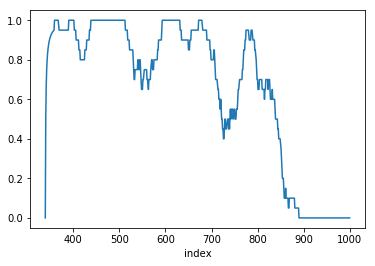

In [16]:
accs = (df_eval['y_pred'] == df_eval['y_true'])
rolling_acc = accs.rolling(20, min_periods=1).mean()
rolling_acc.plot();

Even though our accuracy was much higher, the stability of the model could clearly use some work! Improving the strategies is beyond the scope of this notebook.

Of course this can go a lot further. The labeller and predictor are quite flexible for implementing various strategies. Also, retaining extra information from the run inside the labeller and predictor can be interesting for post run analysis, for example periodically getting and saving the decision function on a grid of points for making animations to visualize the run. Have fun!